>### Imports

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

c:\Users\sel04327\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>### Download the training dataset
- cache() 메서드는 데이터셋을 빠르게 액세스하기 위해 메모리나 디스크에 캐시하는 데 사용.
- 데이터셋을 캐시하면 훈련 프로세스의 성능을 크게 향상
    - 특히 데이터셋이 메모리에 맞지 않을 경우, 캐시를 사용하는 것이 유용합니다. 
    - 또한 I/O 대역폭이 제한되거나 데이터셋 전처리 시간이 오래 걸리는 경우에도 유용합니다.
- 데이터셋을 캐시함으로써 불필요한 데이터 로딩 및 전처리 작업을 피할 수 있으며, 이는 시간을 절약하고 I/O 작업을 saving
    - 이는 특히 대용량 데이터셋이나 다중 에포크를 요구하는 딥러닝 모델을 훈련할 때 유용합니다.

In [8]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config='bicubic_x4')
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split='train', as_supervised=True)
train_cache = train.cache()
# validation data
val = div2k_data.as_dataset(split='validation', as_supervised=True)
val_cache = val.cache()

>### Flip, crop and resize images

In [12]:
def func_flip_LR(lowres_img, highres_img):
    '''Flips Images to left and right'''
    
    # outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    
    return tf.cond(rn < 0.5,
                   lambda: (lowres_img, highres_img),
                   lambda: (tf.image.flip_left_right(lowres_img), tf.image.flip_left_right(highres_img),
                            ),
                   )
    

def func_random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped


def func_random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)

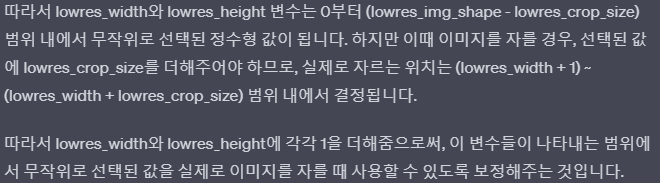

>### tf.data.Dataset 준비

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [13]:
def func_dataset_object(dataset_cache, training=True):
    
    ds = dataset_cache
    
    # num_parallel_reads와 num_parallel_interleave를 설정하여 데이터셋 처리 성능 최적화
    num_parallel_reads = AUTOTUNE
    num_parallel_interleave = AUTOTUNE

    ds = ds.interleave(
        lambda lowres, highres: func_random_crop(lowres, highres, scale=4),  # random_crop 함수를 interleaving
        cycle_length=num_parallel_reads,
        num_parallel_calls=num_parallel_interleave
    )

    if training:
        ds = ds.map(func_random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(func_flip_LR, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(16)  # 배치 처리

    if training:
        ds = ds.repeat()  # 데이터셋을 반복하여 무한한 데이터셋을 생성

    ds = ds.prefetch(buffer_size=AUTOTUNE)  # 데이터를 미리 준비하여 처리 속도 향상

    return ds

train_ds = func_dataset_object(train_cache, training=True)
val_ds = func_dataset_object(val_cache, training=False)

TypeError: The `map_func` argument must return a `Dataset` object. Got <class 'tuple'>.